In [1]:
from vb_utilities import sample_rate_check,BUTTERWORTH,integrate_th,half_cosine_fade_perc,signal_stats
from nptdms import TdmsFile, tdmsinfo
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace,argmax,array
from scipy.signal import correlate,hamming
from scipy.fftpack import fft
from math import atan2
import pandas as pd
from scipy import stats
from numpy import mean,std,zeros,polyfit
import os
from scipy.signal import welch, hanning

Python 3.x


In [2]:
def read_tdms(tdms_file):
    dd=pd.DataFrame([])              # Initialize dataframe
    time=[]
    STA=pd.DataFrame([])              # Initialize dataframe
    Channel_name=[]                  # Initialize Channel name
     
    tdms_groups = tdms_file.groups() # Group information of tdms file
    df=tdms_file.as_dataframe()      # Create dataframe of data in tdms file
    n=len(tdms_groups)               # Number of groups    
    m=df.shape[1]                    # Size of total data (all groups)
    col=int(m/n)                     # Number of Columns (Channels)
    
    #reshaping the dataframe vertifically 
    for i in range(n):               # Iterate n times in for loop        
        df_temp=df.iloc[:, i*col: (i+1)*col]      # Select data from group ith        
        if i==0:        
            df_temp_name=df_temp.columns
            for j in range(col):
                col_name=df_temp_name[j]
                col_name = col_name.split("'/'")
                col_name=col_name[1].replace( "'",  "")
                Channel_name=np.append(Channel_name, col_name)                                                           
            df_temp.columns=Channel_name   
        elif i>=1:
            df_temp.columns=Channel_name
#         # Statistics of data in each group 
        channel_object = tdms_file.object(tdms_groups[i], Channel_name[1])
        t=channel_object.time_track()    
        dt=round(t[1]-t[0],9)
#         SR=[]
#         DT=[] 
#         AVE=[] 
#         SD=[] 
#         RMS=[] 
#         SKE=[] 
#         KUR=[] 
#         DUR=[]
#         for column in range(len(Channel_name)-1):
#             sr,dt,ave,sd,rms,skewness,kurtosis,dur,crest=signal_stats(t, df_temp.iloc[:,column+1], len(df_temp.iloc[:,column+1]))
#             SR=np.append(SR, sr)
#             DT=np.append(DT, dt)
#             AVE=np.append(AVE, ave)
#             SD=np.append(SD, sd)
#             RMS=np.append(RMS, rms)
#             SKE=np.append(SKE, skewness)
#             KUR=np.append(KUR, kurtosis)
#             DUR=np.append(DUR, dur)
            
#         statis = pd.DataFrame({"Average": [AVE],
#                                "Standard Deviation": [SD],
#                                "RMS": [RMS],
#                                "Skewness": [SKE],
#                                "SR": [SR],
#                                "Kurtosis": [KUR]})
#         #end
#         STA=STA.append(statis, ignore_index = True) 
        
        dd=dd.append(df_temp, ignore_index = True)  
        
        
    return dd, Channel_name, dt

In [3]:
f=[]
for filename in os.listdir():
     if filename.endswith('.tdms'):
        f1=filename
        f=np.append(f,f1)
        
tdms_file = TdmsFile(f[0]) 
[data_table, Channel_name, dt]=read_tdms(tdms_file)

In [4]:
print(dt)

0.00015625

In [5]:
#Strain and pulsation sensor is measured as accelerometer to get current and 
#the sensitivity needs to be corrected for
data_table.iloc[:,-2]=data_table.iloc[:,-2]/9.81
data_table.iloc[:,-1]=data_table.iloc[:,-1]/9.81

#Convert from ustrain to stress in MPa through Hookes law. Assuming E=102.7 GPa
#(https://amesweb.info/Materials/Youngs-Modulus-of-Titanium.aspx)
E=102.7e9
data_table.iloc[:,-2]=data_table.iloc[:,-2]*1e-6*E/1e6


fs=1/dt
time = [ i*dt for i in range(len(data_table.iloc[:,0]))]

data_table.iloc[:,0]=time # replacing timestamp with time
    

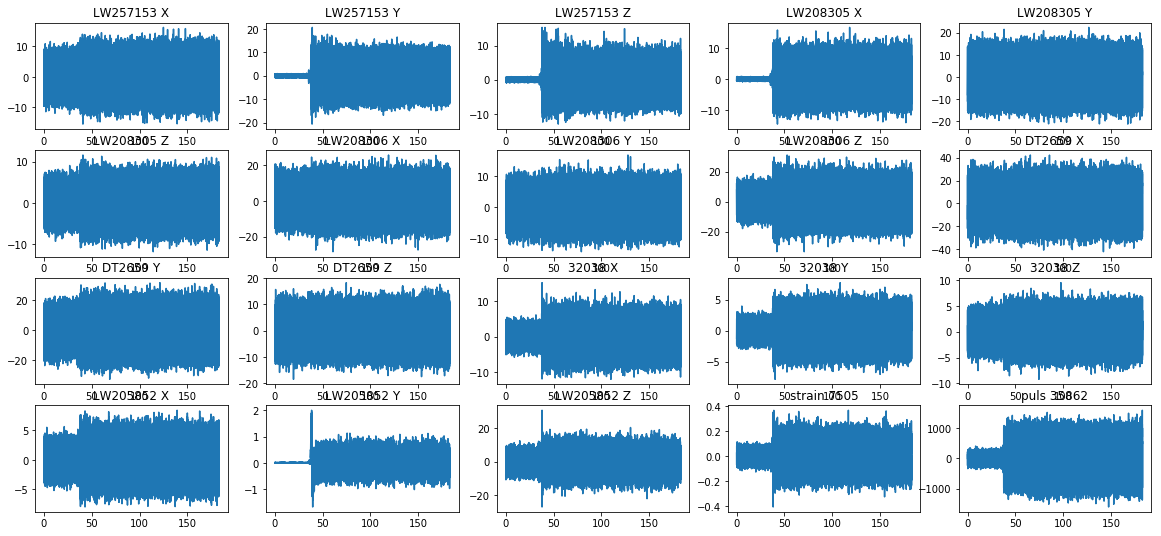

In [6]:

plt.rcParams['figure.figsize'] = [20, 9]
#plot raw  data
plt.figure(1)
for i in range(len(Channel_name)-1):
    plt.subplot(4,5,i+1) 
    plt.plot(time,data_table.iloc[:,i+1])
    plt.title(Channel_name[i+1])

# fig=plt.figure(figsize=(48, 16), dpi= 80, facecolor='w', edgecolor='k')

In [7]:
time_cut=50.0
Time_index_init=data_table.index[data_table['Time'] == time_cut].tolist()
Time_index_finial=data_table.index[data_table['Time'] == time_cut+60.0].tolist()

In [8]:
print(Time_index_init[0],Time_index_finial[0])

320000 704000


In [9]:
data=data_table.iloc[Time_index_init[0]:Time_index_finial[0], :]

Text(0.5, 1.0, 'DT2659 X')

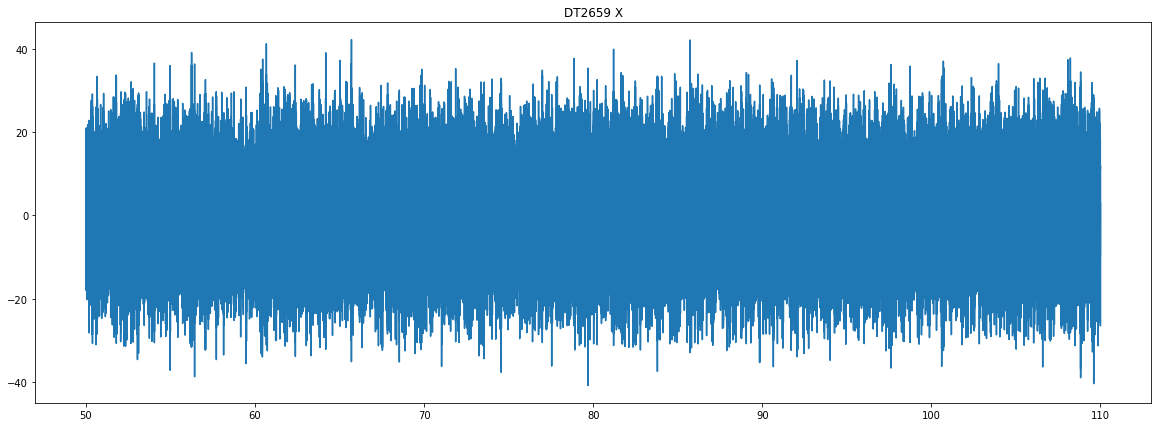

In [39]:
x=data.iloc[:,10]
t=data.iloc[:,0]

fig=plt.rcParams['figure.figsize'] = [20, 7]
plt.figure(1)
plt.plot(t,x) 
plt.title(Channel_name[10])

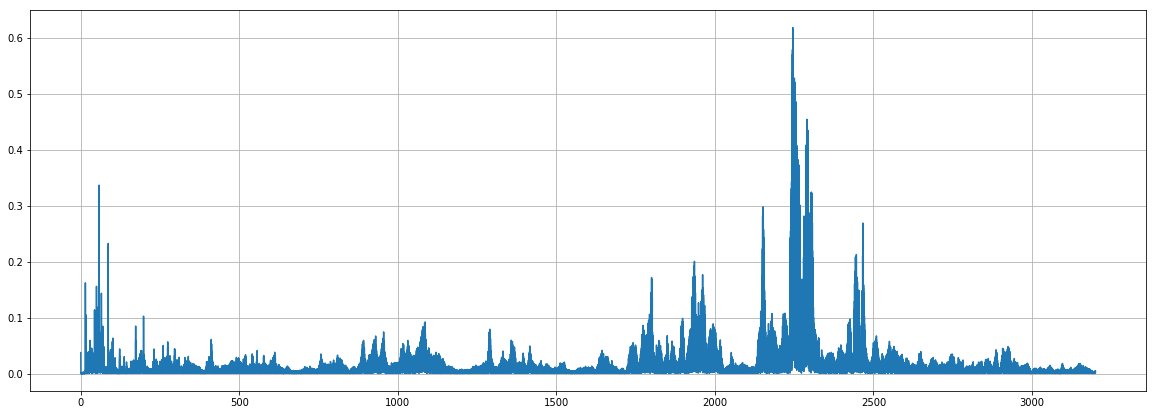

In [22]:
# Genererer fft amplitudespektrum
N=len(x)
xdft = fft(x)
xdft = xdft[0:int(N/2)]
freq1 = np.arange(0,fs/2,fs/len(x)) #0:Fs/length(x):Fs/2
#plt.figure(fnum); fnum=fnum+1;
#Amplitude spectrum is twice single side fft -> stemmer ikke...
plt.plot(freq1,2*abs(xdft)/N);
plt.grid(True)

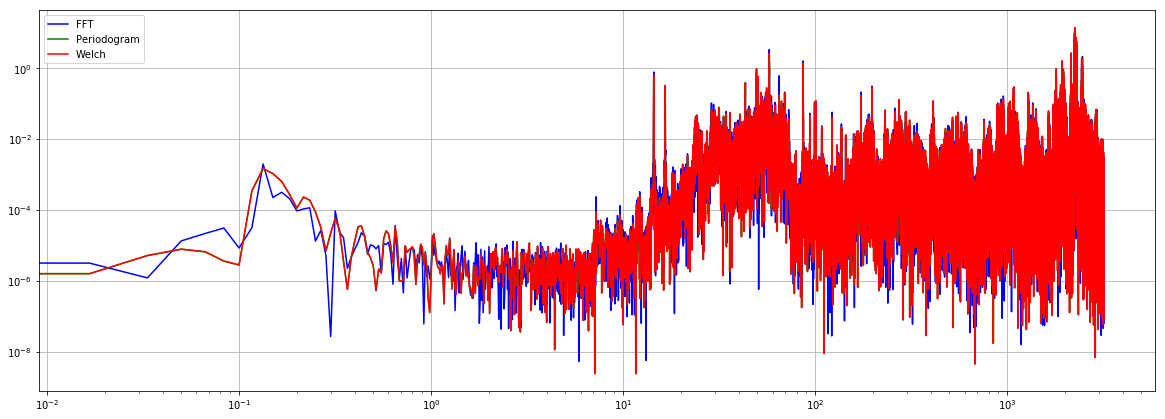

In [46]:
from scipy.signal import welch, hanning, periodogram, get_window
# Generate different psds with equal result
psdx = (1/(fs*N)) * abs(xdft)**2;
psdx[1:-2] = 2*psdx[1:-2]; #psd from dft
win=get_window('hann', N)
freq2, psdpgram = periodogram(x, fs, window=win)
freq3, psdwelch = welch(x, fs, window=win,  nperseg= N, noverlap=N*2/3)
%matplotlib inline
fig=plt.rcParams['figure.figsize'] = [20, 7]
plt.loglog(freq1,psdx, color='blue', label='FFT')
#hold on
plt.loglog(freq2,psdpgram, color='green', label='Periodogram')
plt.loglog(freq3,psdwelch, color='red', label='Welch')
plt.legend()
plt.grid(True)
plt.show()


/home/dp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


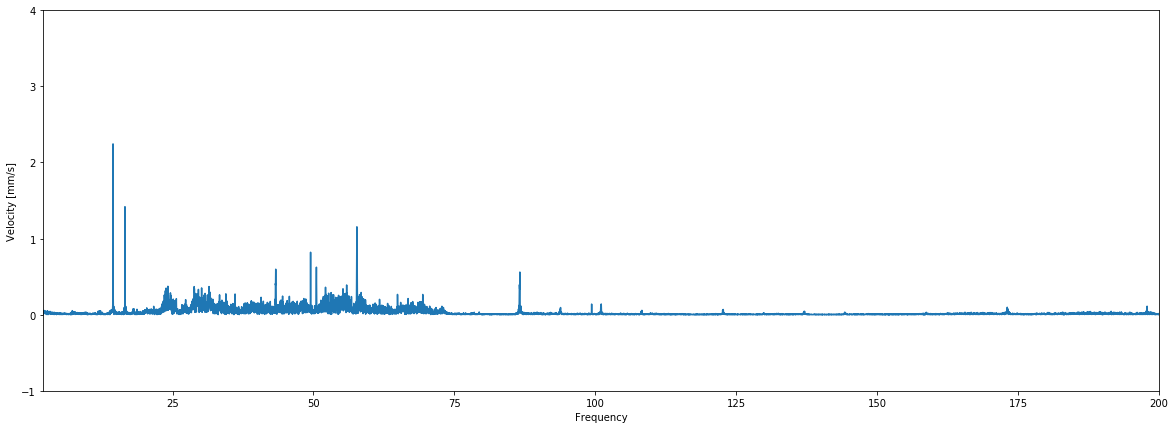

In [37]:
import math
# Convert from acceleration psd from pwelch to displacement through omega arithmetic in the psd domain
psdv=psdwelch/(2*math.pi*freq3)**2; #dividing by w^2 per integration step in psd domain compared to w in the frequency domain
vdft=2*np.sqrt(psdv*fs*N)/N; #Converting to from displacement psd to velocity amplitude spectrum

plt.plot(freq3,vdft*1000)
plt.xlabel('Frequency')
plt.ylabel('Velocity [mm/s]')
plt.xlim((2, 200)); #Low frequency noise is amplified, amplitude slightly offset when N is small
plt.ylim((-1, 4));

/home/dp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/dp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


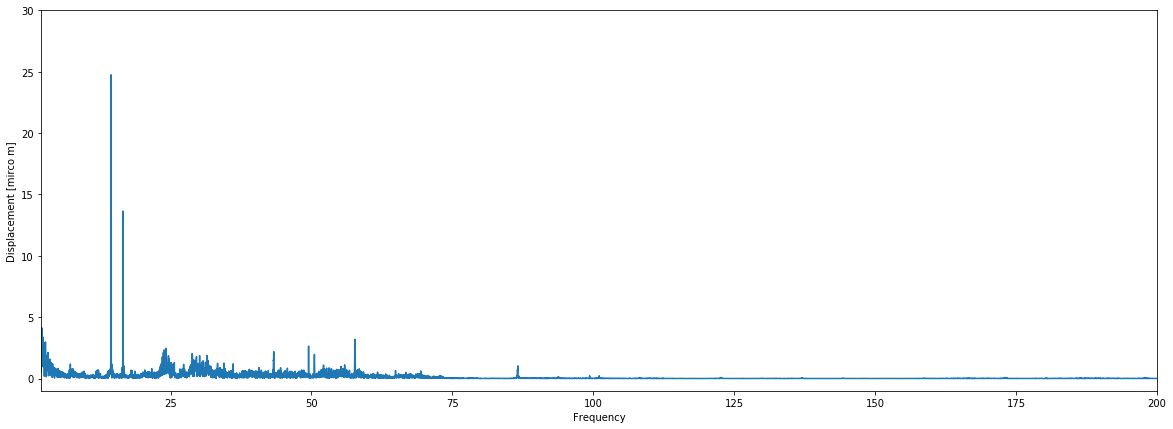

In [38]:
psdd=psdwelch/(2*math.pi*freq3)**4; #dividing by w^2 per integration step in psd domain compared to w in the frequency domain
ddft=2*np.sqrt(psdd*fs*N)/N; #Converting to from displacement psd to displacement amplitude spectrum

plt.plot(freq3,ddft*1e6); 
plt.xlabel('Frequency')
plt.ylabel('Displacement [mirco m]')
plt.xlim((2, 200)); #Low frequency noise is amplified, amplitude slightly offset when N is small
plt.ylim((-1, 30));